In [163]:
import pandas as pd
import numpy as np
import plotly.express as px
import json, csv
import requests
from datetime import datetime
import holidays
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd

In [141]:
%pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Predicting Bike-Sharing Demand in Munich

## Data Collection and Preprocessing


In [142]:
# Data Preprocessing Function
def pre_process_df(df):
    # Strip column names
    df.columns = [col.strip() for col in df.columns]

    # Remove column 'Row'
    df.drop(columns='Row', inplace=True, errors='ignore')

    # Select relevant columns only
    df = df[['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].copy()

    # Make string replacements
    df_obj = df.select_dtypes(include='object')
    df[df_obj.columns] = df_obj.applymap(lambda x: x.strip().replace(',', '.') if isinstance(x, str) else x)

    # Handle datetime 
    df.STARTTIME = pd.to_datetime(df.STARTTIME)

    # Handle numeric columns
    # df.dropna(inplace=True)
    # df.drop(df[df['RENTAL_IS_STATION'] == 'NULL'].index, inplace = True)
    df.replace('NULL', np.NAN, inplace=True)
    df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']] = df[['STARTLAT', 'STARTLON', 'RENTAL_IS_STATION']].astype(np.float32)

    return df

In [143]:
dfs = []
meta = {'years': [], 'n_columns': [], 'n_rows': []}
for year in range(2019, 2023):
    df = pd.read_csv(f'MVG_Rad_Fahrten_{year}.csv', sep=';', low_memory=False)
    df = pre_process_df(df)
    dfs.append(df)
    meta['years'].append(year)
    meta['n_columns'].append(df.shape[1])
    meta['n_rows'].append(df.shape[0])

meta_df = pd.DataFrame(meta)

In [144]:
meta_df

,years,n_columns,n_rows
0,2019,4,753678
1,2020,4,721752
2,2021,4,619573
3,2022,4,709144


In [145]:
# Data Quantity Analysis
fig = px.bar(meta_df, x='years', y='n_rows', labels={'years': 'Year', 'n_rows': 'Number of Rows'}, title='Data Quantity for Each Year')
fig.update_layout(xaxis={'type': 'category', 'categoryorder': 'array', 'categoryarray': sorted(meta_df['years'])})
fig.show()

In [146]:
# Concatenation of DataFrames
df_all = pd.concat((df for df in dfs), axis=0).reset_index(drop=True)
df_all.head(3)

,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION
0,2019-01-01 00:26:00,48.118450,11.51556,1.0
1,2019-01-01 00:32:00,48.138290,11.56943,0.0
2,2019-01-01 00:49:00,48.170971,11.57294,1.0


In [147]:
print(df_all.shape)
df_all.info()

(2804147, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2804147 entries, 0 to 2804146
Data columns (total 4 columns):
 #   Column             Dtype         
---  ------             -----         
 0   STARTTIME          datetime64[ns]
 1   STARTLAT           float32       
 2   STARTLON           float32       
 3   RENTAL_IS_STATION  float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 53.5 MB


In [148]:
df_all.isna().sum()

STARTTIME             0
STARTLAT              0
STARTLON              0
RENTAL_IS_STATION    17
dtype: int64

In [149]:
print(df_all['RENTAL_IS_STATION'].value_counts())

0.0    1998237
1.0     805893
Name: RENTAL_IS_STATION, dtype: int64


In [150]:
# Data Quality Check
duplicate_count = df_all.duplicated().sum()
print("Number of Duplicate Rows:", duplicate_count)

Number of Duplicate Rows: 23408


## Adding Districts and Grouping by Hour

In [151]:
polygons = {}
with open('polygons.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        polygons[row['district']] = Polygon(json.loads(row['coordinates']))

# Create a DataFrame from the polygons dictionary
polygons_df = pd.DataFrame.from_dict(polygons, orient='index', columns=['geometry'])

# Reset the index to make the 'district' column a regular column
polygons_df = polygons_df.reset_index().rename(columns={'index': 'district'})

# Create a GeoDataFrame from the polygons DataFrame
polygons_gdf = gpd.GeoDataFrame(polygons_df)
# Set the geometry column in the polygons_gdf GeoDataFrame
polygons_gdf.set_geometry('geometry', inplace=True)

# Create a GeoDataFrame from the point data
geometry = [Point(row['STARTLON'], row['STARTLAT']) for _, row in df_all.iterrows()]
df_all_geo = gpd.GeoDataFrame(df_all, geometry=geometry)
# Set the geometry column in the df_all_geo GeoDataFrame
df_all_geo.set_geometry('geometry', inplace=True)

# Perform the spatial join
df_all_join = gpd.sjoin(df_all_geo, polygons_gdf, predicate='within')

# Drop unnecessary columns
df_all_join = df_all_join.drop(columns=['geometry', 'index_right'])
# Now, df_all_join will have the districts as columns with True/False values indicating if each point falls within a district


In [157]:
df_all_join['date'] = df_all_join['STARTTIME'].dt.date
df_all_join['year'] = df_all_join['STARTTIME'].dt.year
df_all_join['month'] = df_all_join['STARTTIME'].dt.month
df_all_join['hour'] = df_all_join['STARTTIME'].dt.hour
df_all_join['date_hour'] = df_all_join['STARTTIME'].dt.floor('H')

In [158]:
df_all_join['date_hour'][0]

Timestamp('2019-01-01 00:00:00')

In [159]:
rentals_by_day = df_all_join.groupby('date').size()
rentals_by_month = df_all_join.groupby(['year', 'month']).size()
rentals_by_hour = df_all_join.groupby('date_hour').size()

In [160]:
# Bar chart for rentals by day
fig1 = px.bar(rentals_by_day.index, y=rentals_by_day.values, title='Rental Count by Day')

# Bar chart for rentals by month
fig2 = px.bar(rentals_by_month.index, y=rentals_by_month.values, title='Rental Count by Month')

# Bar chart for rentals by hour
fig3 = px.bar(rentals_by_hour.index, y=rentals_by_hour.values, title='Rental Count by Hour')

# Display the plots
fig1.show()
fig2.show()
fig3.show()

In [161]:
df_all_join.columns

Index(['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION', 'district',
       'date', 'year', 'month', 'hour', 'date_hour'],
      dtype='object')

In [175]:
# Instantiate the OneHotEncoder
district_ohe = OneHotEncoder(sparse_output=False)

# Fit encoder
district_ohe.fit(df_all_join[['district']])

# Apply one-hot encoding and add the encoded columns to the DataFrame
encoded_columns = district_ohe.get_feature_names_out()
encoded_values = district_ohe.transform(df_all_join[['district']])
df_encoded = pd.DataFrame(encoded_values, columns=encoded_columns)

# Update the column names in df_all_join without the prefix 'district_'
column_names = [column.split('district_', 1)[-1] for column in df_encoded.columns]
df_all_join.columns = list(df_all_join.columns[:-len(encoded_columns)]) + column_names
df_all_join.columns

Index(['STARTTIME', 'STARTLAT', 'STARTLON', 'RENTAL_IS_STATION', 'district',
       'date', 'year', 'month', 'hour', 'date_hour', 'Altstadt-Lehel',
       'Au - Haidhausen', 'Aubing-Lochhausen-Langwied', 'Berg am Laim',
       'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')

In [176]:
df_all_join.head(3)

,STARTTIME,STARTLAT,STARTLON,RENTAL_IS_STATION,district,date,year,month,hour,date_hour,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,2019-01-01 00:26:00,48.118450,11.51556,1.0,Sendling-Westpark,2019-01-01,2019,1,0,2019-01-01 00:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01 00:58:00,48.117119,11.52634,1.0,Sendling-Westpark,2019-01-01,2019,1,0,2019-01-01 00:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,2019-01-01 04:31:00,48.118450,11.51556,1.0,Sendling-Westpark,2019-01-01,2019,1,4,2019-01-01 04:00:00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
# Grouping by Hour
df_by_hour = df_all_join.groupby('date_hour').agg({
    'RENTAL_IS_STATION': np.mean,
    'year': np.mean,
    'month': np.mean,
    'hour': np.mean,
    **{district: np.sum for district in df_all_join['district']}
}).reset_index()

In [178]:
print(df_by_hour.shape)
df_by_hour.head(3)

(34632, 39)


,date_hour,RENTAL_IS_STATION,year,month,hour,Sendling-Westpark,Altstadt-Lehel,Schwabing-West,Untergiesing,Untergiesing-Harlaching,...,Südgiesing,Pasing,Pasing-Obermenzing,Hasenbergl-Lerchenau Ost,Obermenzing,Trudering,Trudering-Riem,Feldmoching,Untermenzing-Allach,Lochhausen
0,2019-01-01 00:00:00,0.666667,2019.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.428571,2019.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-01-01 02:00:00,0.720000,2019.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
df_by_hour.to_csv('districts_demand_df_by_hour.csv', index=False)

In [180]:
# Distribution of 'RENTAL_IS_STATION' variables
fig = px.histogram(df_by_hour, x='RENTAL_IS_STATION', nbins=25, labels={'RENTAL_IS_STATION': 'Rental Type'}, title='Distribution of Rental Types')
fig.show()

In [234]:
# Geospatial Analysis
district_counts = df_by_hour.iloc[:, -34:].sum(numeric_only=True).sort_values(ascending=False)
district_counts.head(3)

Maxvorstadt                     388868.0
Ludwigsvorstadt-Isarvorstadt    264212.0
Schwabing-Freimann              251164.0
dtype: float64

In [235]:
fig = px.bar(x=district_counts.index, y=district_counts.values, labels={'x': 'District', 'y': 'Rental Count'}, title='Rental Count by District')
fig.update_layout(xaxis_tickangle=-90)
fig.show()

## Aggregating with Weather Data




In [190]:
# Fetch weather data
url = "https://archive-api.open-meteo.com/v1/era5"
params = {
    'latitude': 48.14,
    'longitude': 11.58,
    'start_date': '2019-01-01',
    'end_date': '2022-12-31',
    'hourly': ['temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'windspeed_10m', 'precipitation']
}
weather_data = requests.get(url, params=params).json()
df_weather = pd.DataFrame(weather_data['hourly'])
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  35064 non-null  datetime64[ns]
 1   temperature_2m        35064 non-null  float64       
 2   relativehumidity_2m   35064 non-null  int64         
 3   apparent_temperature  35064 non-null  float64       
 4   windspeed_10m         35064 non-null  float64       
 5   precipitation         35064 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.6 MB


In [187]:
# Read df_by_hour data from csv file
df_by_hour = pd.read_csv('districts_demand_df_by_hour.csv', parse_dates=True, date_parser={'STARTTIME':'%Y-%M-%d %H:%m:%s'})
df_by_hour.head(2)

,date_hour,RENTAL_IS_STATION,year,month,hour,Sendling-Westpark,Altstadt-Lehel,Schwabing-West,Untergiesing,Untergiesing-Harlaching,...,Südgiesing,Pasing,Pasing-Obermenzing,Hasenbergl-Lerchenau Ost,Obermenzing,Trudering,Trudering-Riem,Feldmoching,Untermenzing-Allach,Lochhausen
0,2019-01-01 00:00:00,0.666667,2019.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01 01:00:00,0.428571,2019.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
# Merge bike rental data with weather data
# Convert the 'date_hour' column in df_by_hour to datetime
df_by_hour['date_hour'] = pd.to_datetime(df_by_hour['date_hour'])

# Merge bike rental data with weather data
data = df_by_hour.merge(df_weather, left_on='date_hour', right_on='time', how='left').drop(columns='time')

data['date_hour'] = pd.to_datetime(data['date_hour'])

In [192]:
print(data.shape)
data.head(2)

(34632, 44)


,date_hour,RENTAL_IS_STATION,year,month,hour,Sendling-Westpark,Altstadt-Lehel,Schwabing-West,Untergiesing,Untergiesing-Harlaching,...,Trudering,Trudering-Riem,Feldmoching,Untermenzing-Allach,Lochhausen,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
0,2019-01-01 00:00:00,0.666667,2019.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.3,97,0.2,9.8,0.0
1,2019-01-01 01:00:00,0.428571,2019.0,1.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,97,-0.1,9.9,0.0


In [193]:
data.columns

Index(['date_hour', 'RENTAL_IS_STATION', 'year', 'month', 'hour',
       'Sendling-Westpark', 'Altstadt-Lehel', 'Schwabing-West', 'Untergiesing',
       'Untergiesing-Harlaching', 'Maxvorstadt', 'Bogenhausen', 'Sendling',
       'Milbertshofen-Am Hart', 'Neuhausen-Nymphenburg', 'Moosach',
       'Obergiesing', 'Au - Haidhausen', 'Ludwigsvorstadt-Isarvorstadt',
       'Laim', 'Schwanthalerhöhe', 'Schwabing-Freimann', 'Ramersdorf-Perlach',
       'Thalkirchen', 'Aubing-Lochhausen-Langwied', 'Hadern', 'Berg am Laim',
       'Harlaching', 'Obersendling', 'Südgiesing', 'Pasing',
       'Pasing-Obermenzing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing',
       'Trudering', 'Trudering-Riem', 'Feldmoching', 'Untermenzing-Allach',
       'Lochhausen', 'temperature_2m', 'relativehumidity_2m',
       'apparent_temperature', 'windspeed_10m', 'precipitation'],
      dtype='object')

## Features and Target

In [194]:
data['date_hour'] = data['date_hour'].apply(pd.to_datetime)
data['date'] = data['date_hour'].apply(lambda x: datetime.date(x))

X = data[['date', 'date_hour', 'year', 'month', 'hour', 'RENTAL_IS_STATION', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation']].copy()


In [195]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34632 entries, 0 to 34631
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  34632 non-null  object        
 1   date_hour             34632 non-null  datetime64[ns]
 2   year                  34632 non-null  float64       
 3   month                 34632 non-null  float64       
 4   hour                  34632 non-null  float64       
 5   RENTAL_IS_STATION     34632 non-null  float64       
 6   temperature_2m        34632 non-null  float64       
 7   relativehumidity_2m   34632 non-null  int64         
 8   apparent_temperature  34632 non-null  float64       
 9   windspeed_10m         34632 non-null  float64       
 10  precipitation         34632 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 3.2+ MB


In [196]:
X.describe()

,year,month,hour,RENTAL_IS_STATION,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation
count,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000
mean,2020.498643,6.552408,11.591823,0.269889,9.685063,77.046575,7.553052,9.751787,0.112740
std,1.119856,3.431669,6.897799,0.142486,7.872918,15.777617,9.548637,5.848159,0.367826
min,2019.000000,1.000000,0.000000,0.000000,-17.100000,25.000000,-22.400000,0.000000,0.000000
25%,2019.000000,4.000000,6.000000,0.197368,3.200000,66.000000,-0.400000,5.900000,0.000000
50%,2020.000000,7.000000,12.000000,0.254237,9.400000,81.000000,6.800000,8.300000,0.000000
75%,2022.000000,10.000000,18.000000,0.326087,15.700000,90.000000,15.000000,12.200000,0.000000
max,2022.000000,12.000000,23.000000,1.000000,32.100000,100.000000,35.900000,52.600000,11.100000


In [198]:
y = data[['date_hour','Sendling-Westpark', 'Altstadt-Lehel', 'Schwabing-West', 'Untergiesing',
       'Untergiesing-Harlaching', 'Maxvorstadt', 'Bogenhausen', 'Sendling',
       'Milbertshofen-Am Hart', 'Neuhausen-Nymphenburg', 'Moosach',
       'Obergiesing', 'Au - Haidhausen', 'Ludwigsvorstadt-Isarvorstadt',
       'Laim', 'Schwanthalerhöhe', 'Schwabing-Freimann', 'Ramersdorf-Perlach',
       'Thalkirchen', 'Aubing-Lochhausen-Langwied', 'Hadern', 'Berg am Laim',
       'Harlaching', 'Obersendling', 'Südgiesing', 'Pasing',
       'Pasing-Obermenzing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing',
       'Trudering', 'Trudering-Riem', 'Feldmoching', 'Untermenzing-Allach',
       'Lochhausen']].copy()

In [199]:
y.describe()

,Sendling-Westpark,Altstadt-Lehel,Schwabing-West,Untergiesing,Untergiesing-Harlaching,Maxvorstadt,Bogenhausen,Sendling,Milbertshofen-Am Hart,Neuhausen-Nymphenburg,...,Südgiesing,Pasing,Pasing-Obermenzing,Hasenbergl-Lerchenau Ost,Obermenzing,Trudering,Trudering-Riem,Feldmoching,Untermenzing-Allach,Lochhausen
count,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,...,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000
mean,1.570542,6.716967,5.513571,1.842804,1.842804,11.228575,2.383085,3.181566,3.918457,6.290310,...,0.124942,0.362208,0.528471,0.111920,0.076634,0.330446,0.330446,0.056422,0.019577,0.012705
std,2.114272,8.620787,5.652932,2.511722,2.511722,11.203194,3.025092,3.999474,4.988386,6.678887,...,0.392546,0.779462,1.014576,0.394374,0.320559,0.770781,0.770781,0.295097,0.157835,0.138928
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,1.000000,2.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,9.000000,8.000000,3.000000,3.000000,17.000000,3.000000,5.000000,6.000000,9.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,19.000000,75.000000,55.000000,24.000000,24.000000,93.000000,39.000000,38.000000,121.000000,65.000000,...,6.000000,11.000000,11.000000,9.000000,7.000000,13.000000,13.000000,7.000000,6.000000,5.000000


## Feature engineering - Weekends and holidays

In [200]:
X['date'] = pd.to_datetime(X['date'])
X['is_weekend'] = X['date'].dt.weekday >= 5

bay_holidays = holidays.CountryHoliday('DE', prov='BY')
X['is_holiday'] = X['date'].apply(lambda x: x in bay_holidays)

X.drop(columns=['RENTAL_IS_STATION', 'year', 'month', 'hour'], inplace=True)
#X.reset_index(inplace=True)
#X.rename(columns={'index': 'date_hour'}, inplace=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34632 entries, 0 to 34631
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  34632 non-null  datetime64[ns]
 1   date_hour             34632 non-null  datetime64[ns]
 2   temperature_2m        34632 non-null  float64       
 3   relativehumidity_2m   34632 non-null  int64         
 4   apparent_temperature  34632 non-null  float64       
 5   windspeed_10m         34632 non-null  float64       
 6   precipitation         34632 non-null  float64       
 7   is_weekend            34632 non-null  bool          
 8   is_holiday            34632 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(4), int64(1)
memory usage: 2.2 MB


In [201]:
numeric_columns = y.select_dtypes(include=np.number).columns
y['total_rentals'] = y[numeric_columns].sum(axis=1)
y.describe()

,Sendling-Westpark,Altstadt-Lehel,Schwabing-West,Untergiesing,Untergiesing-Harlaching,Maxvorstadt,Bogenhausen,Sendling,Milbertshofen-Am Hart,Neuhausen-Nymphenburg,...,Pasing,Pasing-Obermenzing,Hasenbergl-Lerchenau Ost,Obermenzing,Trudering,Trudering-Riem,Feldmoching,Untermenzing-Allach,Lochhausen,total_rentals
count,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,...,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000,34632.000000
mean,1.570542,6.716967,5.513571,1.842804,1.842804,11.228575,2.383085,3.181566,3.918457,6.290310,...,0.362208,0.528471,0.111920,0.076634,0.330446,0.330446,0.056422,0.019577,0.012705,76.492146
std,2.114272,8.620787,5.652932,2.511722,2.511722,11.203194,3.025092,3.999474,4.988386,6.678887,...,0.779462,1.014576,0.394374,0.320559,0.770781,0.770781,0.295097,0.157835,0.138928,75.706736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,1.000000,2.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000
75%,2.000000,9.000000,8.000000,3.000000,3.000000,17.000000,3.000000,5.000000,6.000000,9.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000
max,19.000000,75.000000,55.000000,24.000000,24.000000,93.000000,39.000000,38.000000,121.000000,65.000000,...,11.000000,11.000000,9.000000,7.000000,13.000000,13.000000,7.000000,6.000000,5.000000,699.000000


In [202]:
X.columns

Index(['date', 'date_hour', 'temperature_2m', 'relativehumidity_2m',
       'apparent_temperature', 'windspeed_10m', 'precipitation', 'is_weekend',
       'is_holiday'],
      dtype='object')

In [203]:
y.columns

Index(['date_hour', 'Sendling-Westpark', 'Altstadt-Lehel', 'Schwabing-West',
       'Untergiesing', 'Untergiesing-Harlaching', 'Maxvorstadt', 'Bogenhausen',
       'Sendling', 'Milbertshofen-Am Hart', 'Neuhausen-Nymphenburg', 'Moosach',
       'Obergiesing', 'Au - Haidhausen', 'Ludwigsvorstadt-Isarvorstadt',
       'Laim', 'Schwanthalerhöhe', 'Schwabing-Freimann', 'Ramersdorf-Perlach',
       'Thalkirchen', 'Aubing-Lochhausen-Langwied', 'Hadern', 'Berg am Laim',
       'Harlaching', 'Obersendling', 'Südgiesing', 'Pasing',
       'Pasing-Obermenzing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing',
       'Trudering', 'Trudering-Riem', 'Feldmoching', 'Untermenzing-Allach',
       'Lochhausen', 'total_rentals'],
      dtype='object')

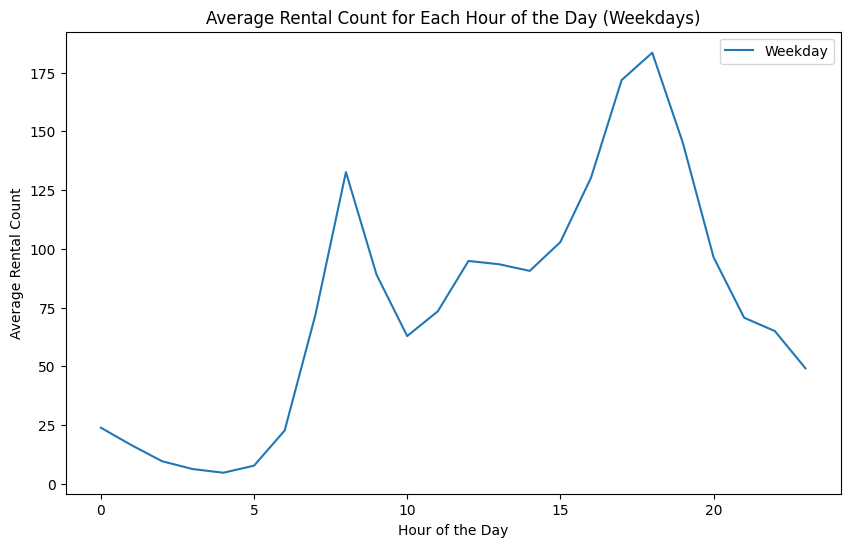

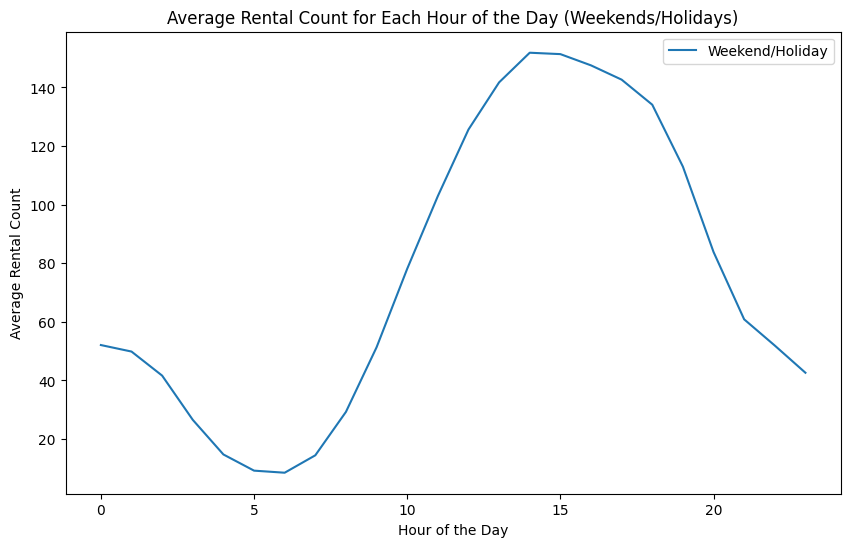

In [216]:
# Extract the hour component from the 'date_hour' column
df['hour'] = pd.to_datetime(df['date_hour']).dt.hour

# Separate the data for weekdays and weekends/holidays
weekday_data = df[df['day_of_week'] < 5]
weekend_data = df[df['day_of_week'] >= 5]

# Calculate the average rental count for each hour of the day for weekdays and weekends/holidays
weekday_avg_rentals = weekday_data.groupby('hour')['total_rentals'].mean()
weekend_avg_rentals = weekend_data.groupby('hour')['total_rentals'].mean()

# Plot the average rental count for each hour of the day for weekdays
plt.figure(figsize=(10, 6))
plt.plot(weekday_avg_rentals.index, weekday_avg_rentals.values, label='Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rental Count')
plt.title('Average Rental Count for Each Hour of the Day (Weekdays)')
plt.legend()
plt.show()

# Plot the average rental count for each hour of the day for weekends/holidays
plt.figure(figsize=(10, 6))
plt.plot(weekend_avg_rentals.index, weekend_avg_rentals.values, label='Weekend/Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rental Count')
plt.title('Average Rental Count for Each Hour of the Day (Weekends/Holidays)')
plt.legend()
plt.show()

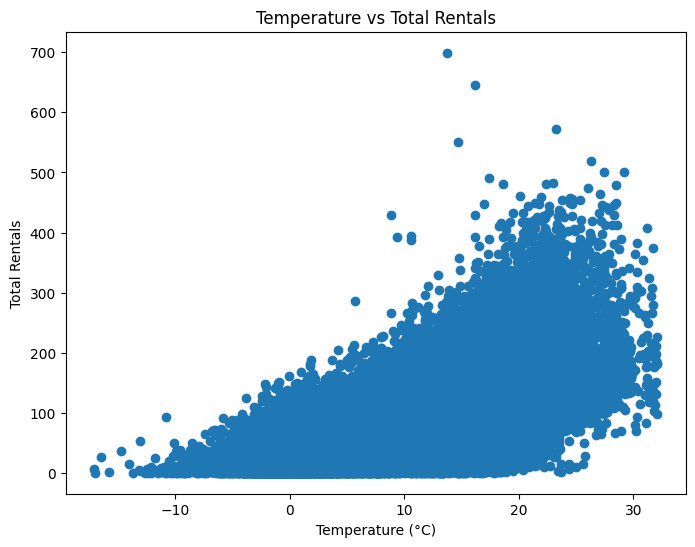

In [206]:
# Weather Data Analysis - temperature Vs Total rentals scatter plot
temperature = X['temperature_2m']

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(temperature, y['total_rentals'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Rentals')
plt.title('Temperature vs Total Rentals')
plt.show()

## Exploratory Data Analysis

In [207]:
# Group rentals by day
y['date_hour'] = pd.to_datetime(y['date_hour'])
y['date'] = y['date_hour'].apply(lambda x: x.date())
y_by_day = y.groupby('date').sum(numeric_only=True)

# Group rentals by month
y['year_month'] = y['date_hour'].apply(lambda x: pd.to_datetime(f'{x.year}-{x.month}'))
y_by_month = y.groupby('year_month').sum(numeric_only=True)

In [208]:
fig = go.Figure()

# Line plot for total rentals by day
fig.add_trace(go.Scatter(x=rentals_by_day.index, y=rentals_by_day.values, name='Total Rentals by Day'))
fig.show()

fig = go.Figure()

# Line plots for rentals by month for different districts
fig.add_trace(go.Scatter(x=y_by_month.index, y=y_by_month['Maxvorstadt'], name='Maxvorstadt'))
fig.add_trace(go.Scatter(x=y_by_month.index, y=y_by_month['Altstadt-Lehel'], name='Altstadt-Lehel'))
fig.add_trace(go.Scatter(x=y_by_month.index, y=y_by_month['Sendling'], name='Sendling'))
fig.add_trace(go.Scatter(x=y_by_month.index, y=y_by_month['Laim'], name='Laim'))
fig.add_trace(go.Scatter(x=y_by_month.index, y=y_by_month['Pasing'], name='Pasing'))

# Update layout
fig.update_layout(title='Total Number of Bike Rentals 2019-2022 (by Day) and Rentals by Month for Different Districts',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Rentals'))

# Display the figure
fig.show()


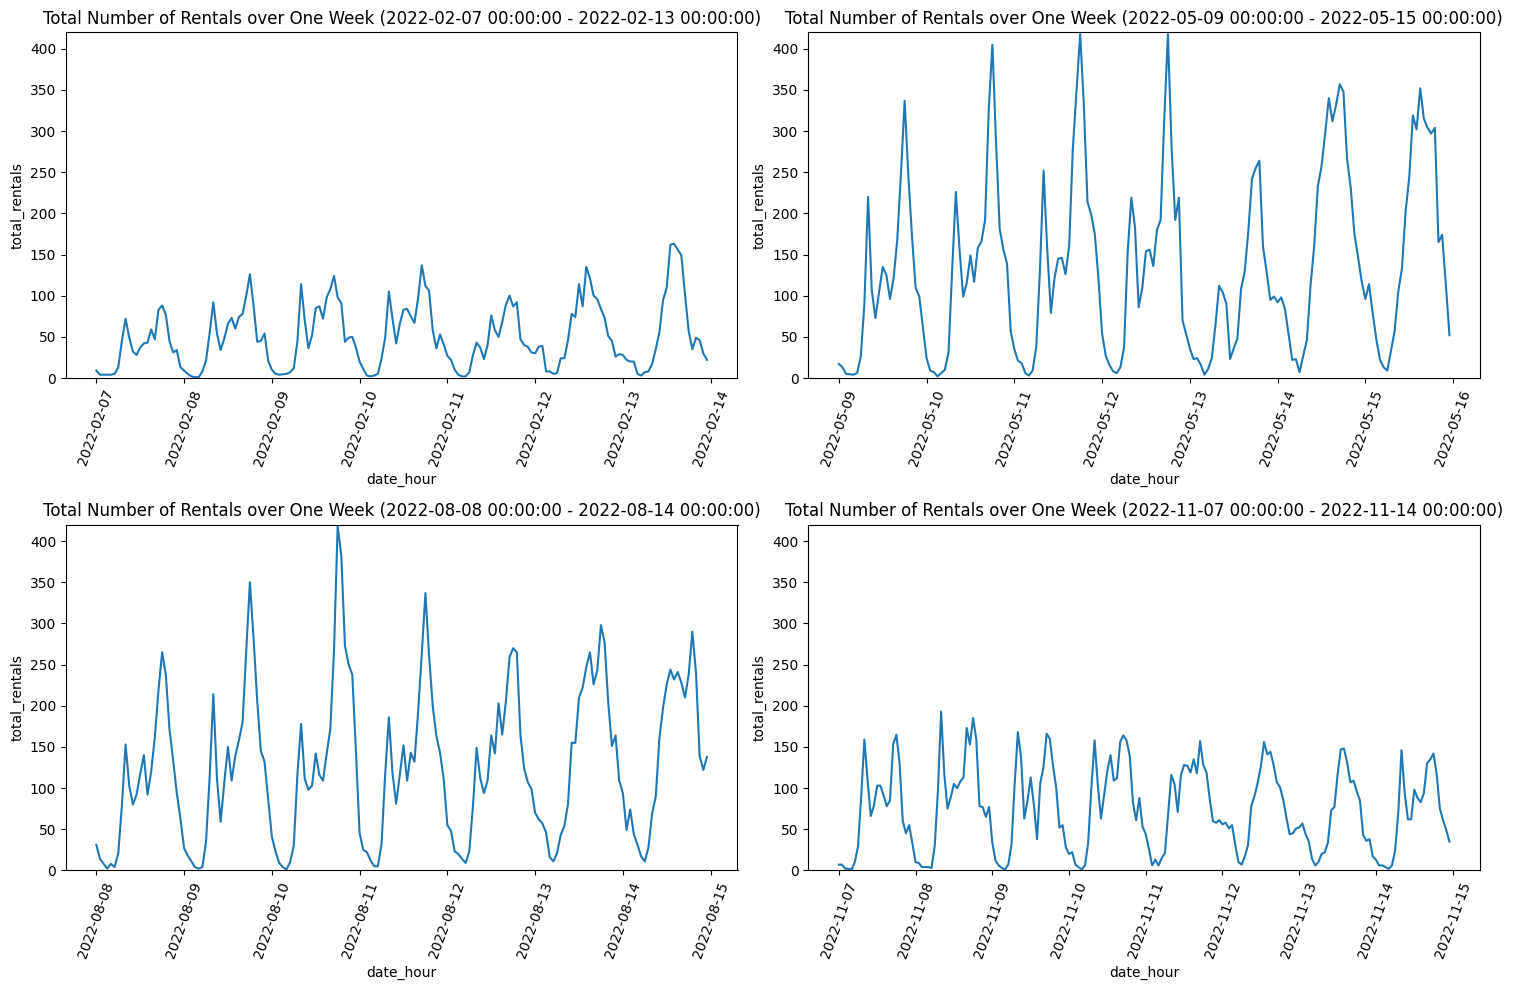

In [209]:
# Analysis of Random Weeks
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

dates = [['2022-02-07', '2022-02-13'], ['2022-05-09', '2022-05-15'], ['2022-08-08', '2022-08-14'], ['2022-11-07', '2022-11-14']]

for i in range(2):
    for j in range(2):
        start_date, end_date = dates[i*2+j]
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        y_rnd_week = y[(y['date'] >= pd.to_datetime(start_date).date()) & (y['date'] <= pd.to_datetime(end_date).date())]
        sns.lineplot(x='date_hour', y='total_rentals', data=y_rnd_week, ax=ax[i,j])
        ax[i,j].set_title(f'Total Number of Rentals over One Week ({start_date} - {end_date})')
        ax[i,j].set_ylim(0, 420)
        ax[i,j].tick_params(axis='x', rotation=70)

plt.tight_layout()
plt.show()

In [210]:
data.columns

Index(['date_hour', 'RENTAL_IS_STATION', 'year', 'month', 'hour',
       'Sendling-Westpark', 'Altstadt-Lehel', 'Schwabing-West', 'Untergiesing',
       'Untergiesing-Harlaching', 'Maxvorstadt', 'Bogenhausen', 'Sendling',
       'Milbertshofen-Am Hart', 'Neuhausen-Nymphenburg', 'Moosach',
       'Obergiesing', 'Au - Haidhausen', 'Ludwigsvorstadt-Isarvorstadt',
       'Laim', 'Schwanthalerhöhe', 'Schwabing-Freimann', 'Ramersdorf-Perlach',
       'Thalkirchen', 'Aubing-Lochhausen-Langwied', 'Hadern', 'Berg am Laim',
       'Harlaching', 'Obersendling', 'Südgiesing', 'Pasing',
       'Pasing-Obermenzing', 'Hasenbergl-Lerchenau Ost', 'Obermenzing',
       'Trudering', 'Trudering-Riem', 'Feldmoching', 'Untermenzing-Allach',
       'Lochhausen', 'temperature_2m', 'relativehumidity_2m',
       'apparent_temperature', 'windspeed_10m', 'precipitation', 'date'],
      dtype='object')

## Correlation Analysis

In [224]:
X.columns

Index(['date', 'date_hour', 'temperature_2m', 'relativehumidity_2m',
       'apparent_temperature', 'windspeed_10m', 'precipitation', 'is_weekend',
       'is_holiday', 'day_of_week'],
      dtype='object')

<ipython-input-225-2c1af496e319>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



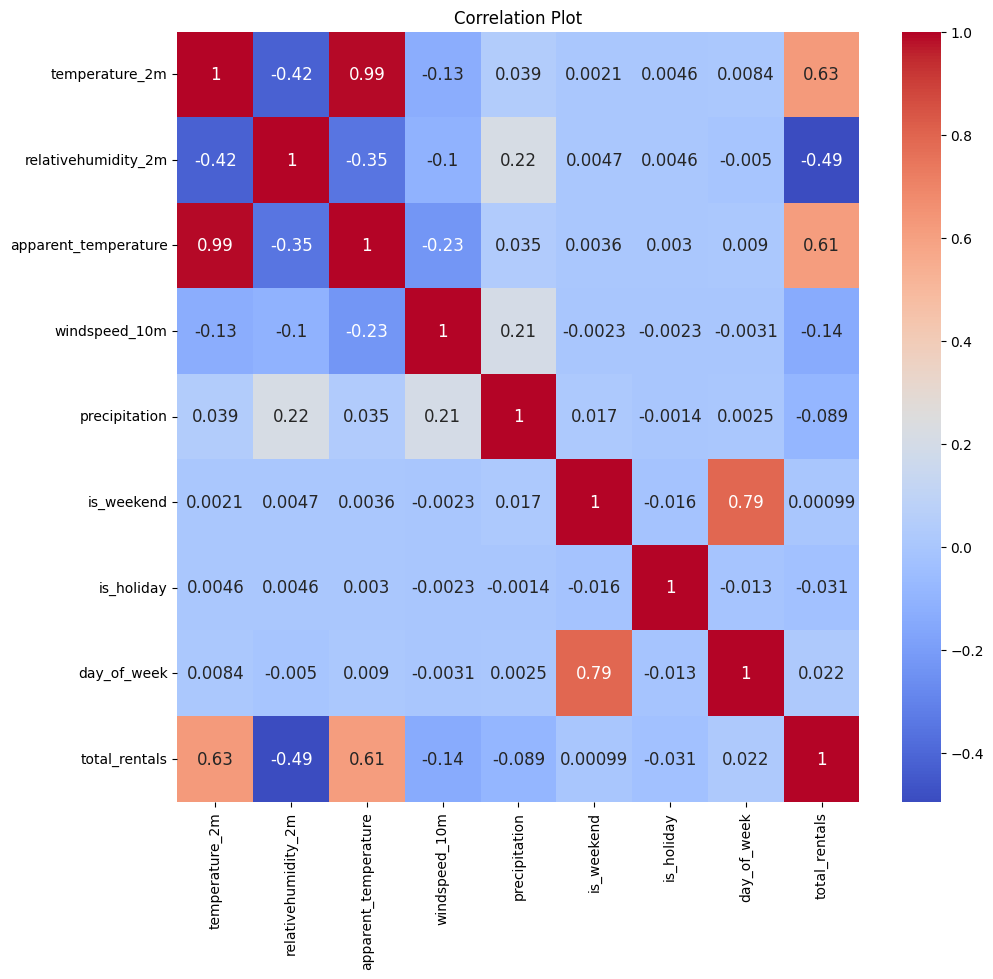

In [225]:
# Concatenate X and y DataFrames
all_data = pd.concat([X, y['total_rentals']], axis=1)

# Calculate the correlation matrix
correlation_matrix = all_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(11, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 12})
plt.title('Correlation Plot')
plt.show()

In [226]:
round(np.abs(correlation_matrix['total_rentals']).sort_values(ascending = False),2)

total_rentals           1.00
temperature_2m          0.63
apparent_temperature    0.61
relativehumidity_2m     0.49
windspeed_10m           0.14
precipitation           0.09
is_holiday              0.03
day_of_week             0.02
is_weekend              0.00
Name: total_rentals, dtype: float64

<__array_function__ internals>:180: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:180: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



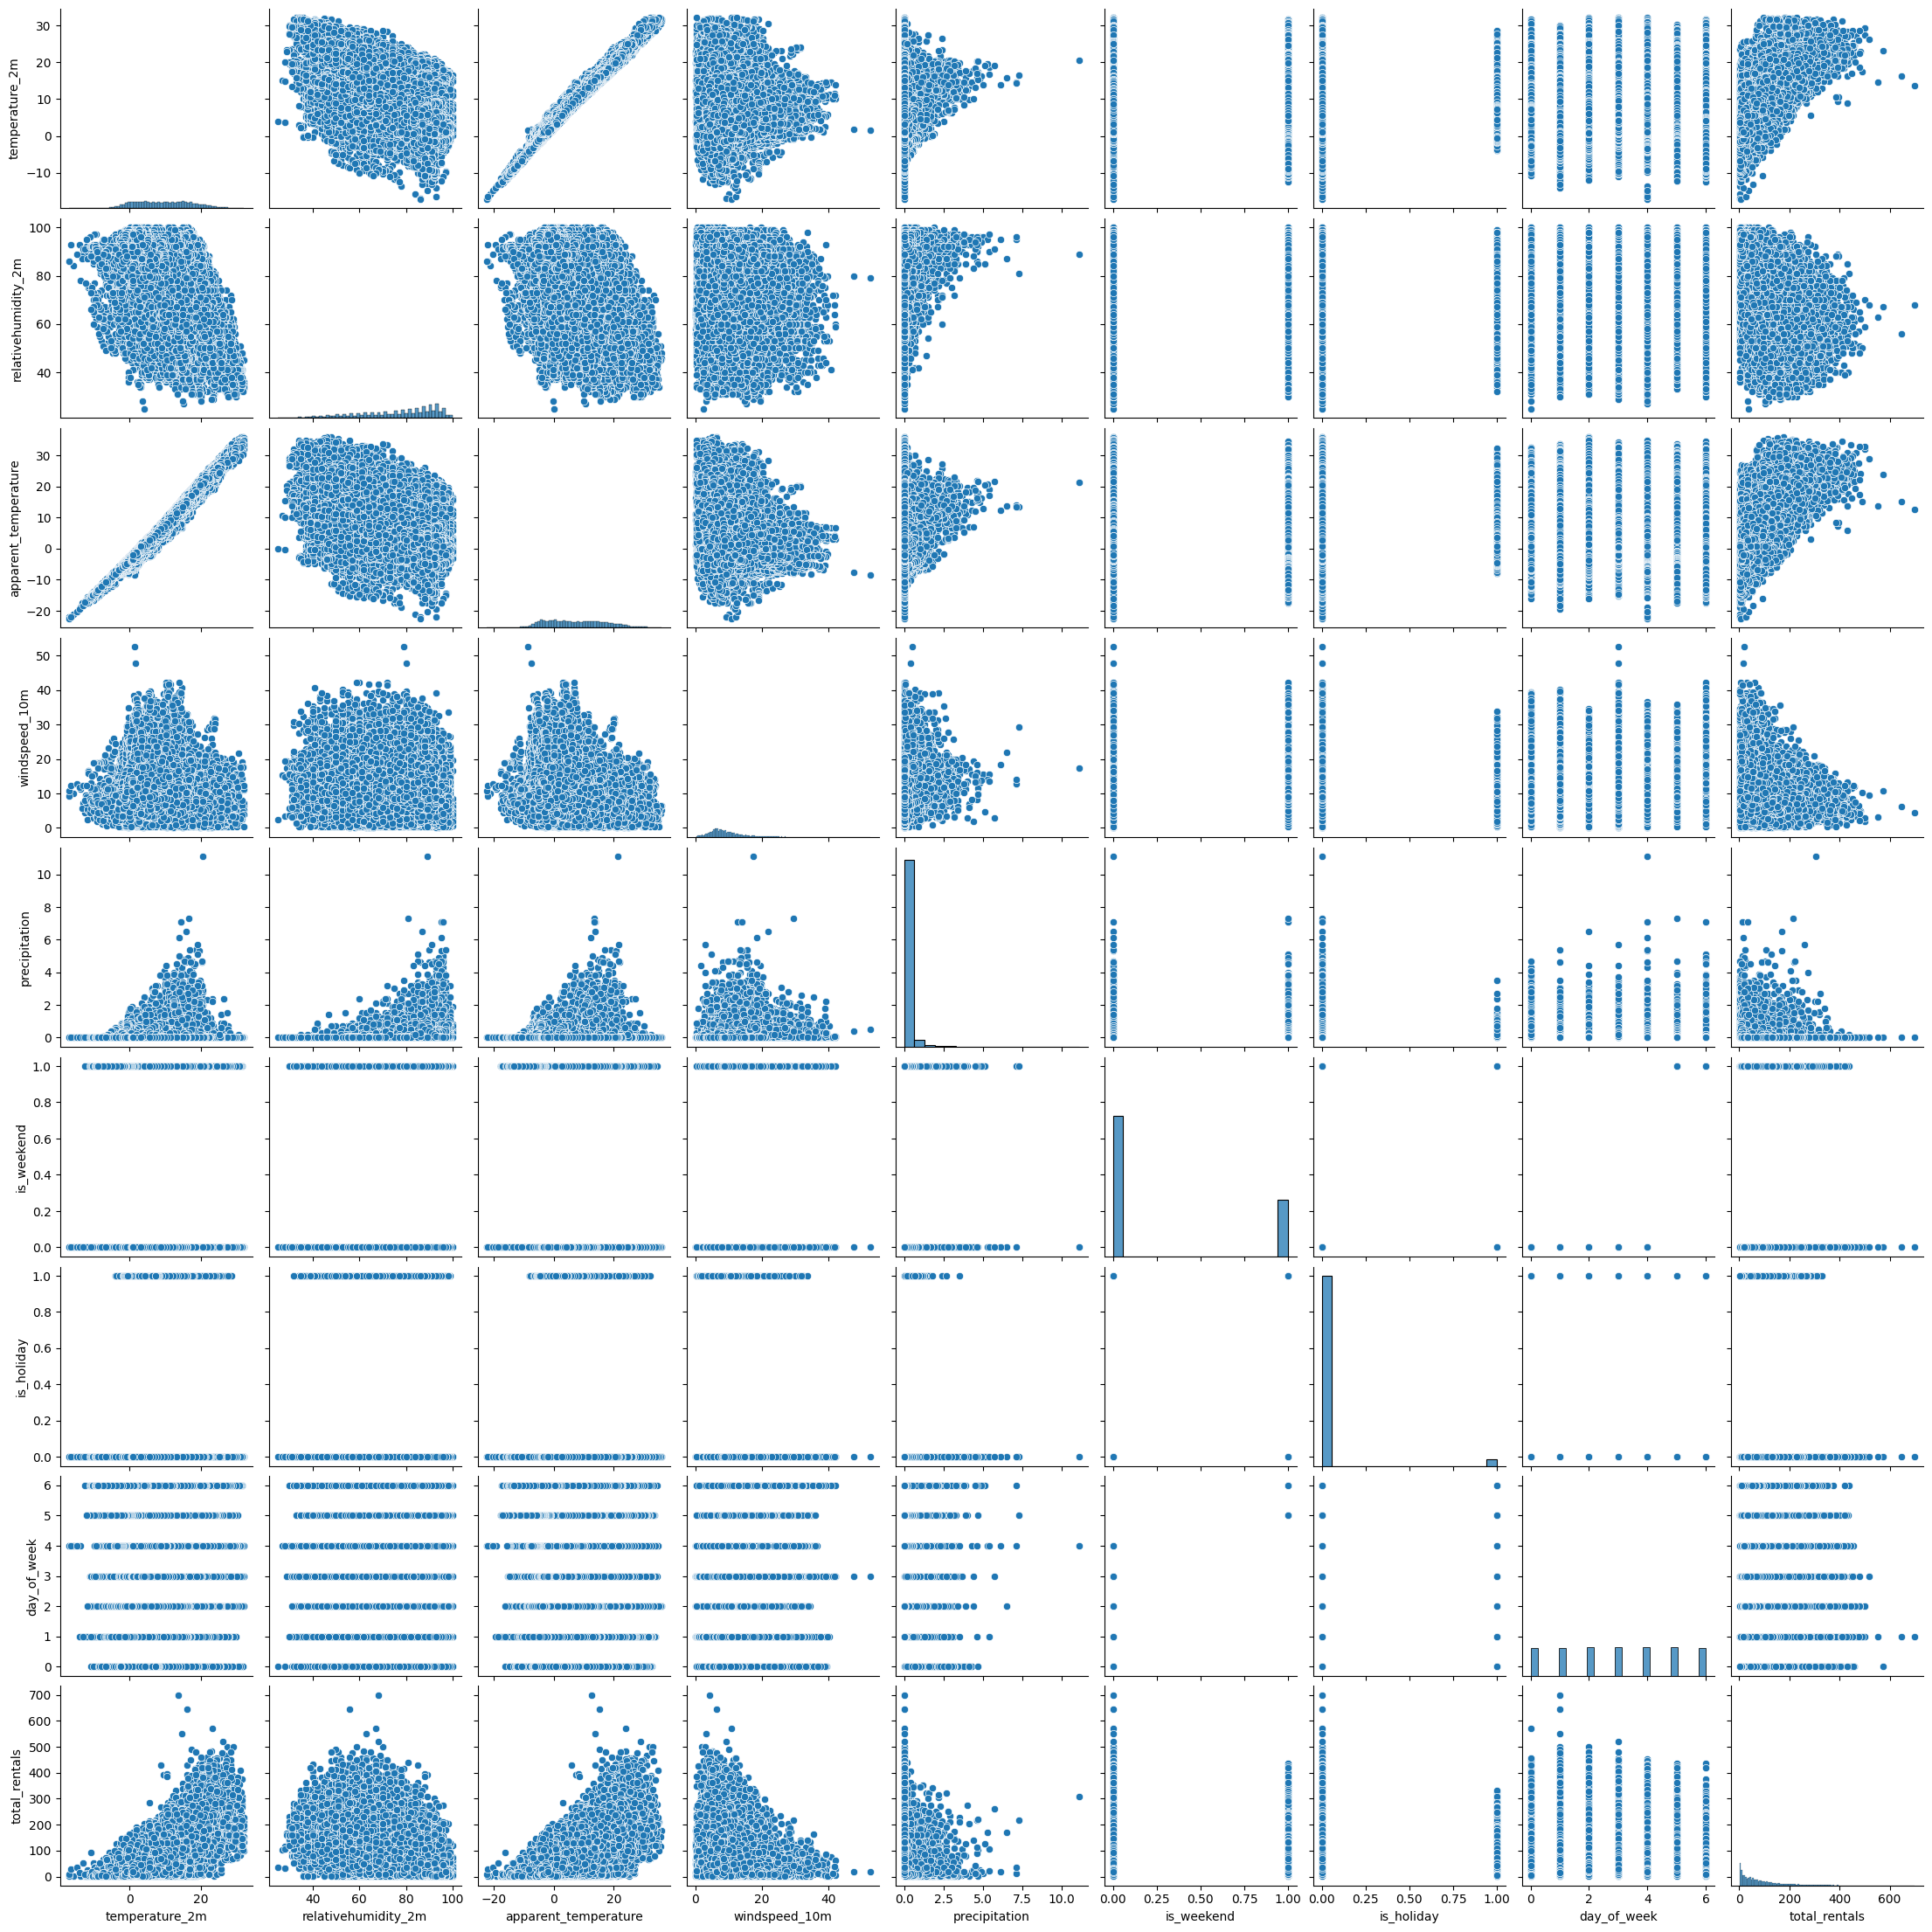

In [228]:
# Pairplot of variables
sns.pairplot(all_data);